In [237]:
# need to check how to align waveforms in time and phase

In [238]:
import qnm

# qnm.download_data()

In [239]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [240]:
import re
import glob
import os
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import numpy as np
import pandas as pd
import pathlib
import copy

In [241]:
import nr_utils

In [242]:
import lmfit

In [243]:
import scipy.optimize
from scipy.signal import savgol_filter

In [244]:
import phenom

In [245]:
### Need to modify this by the energy radiated as qnm assumes total mass of 1M i guess
def get_angular_ringdown_frequency_from_bbh(q, l, m, n=0):
    eta = phenom.eta_from_q(q)
    remnant_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    e_rad = phenom.remnant.EradRational0815(eta, 0, 0)

    mc = qnm.modes_cache(s=-2,l=l,m=m,n=n)
    omega, _, _ = mc(a=remnant_spin)
    remnant_mass = (1 - e_rad)
    return np.real(omega) / remnant_mass
    
def get_angular_damping_frequency_from_bbh(q, l, m, n=0):
    eta = phenom.eta_from_q(q)
    remnant_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    e_rad = phenom.remnant.EradRational0815(eta, 0, 0)

    mc = qnm.modes_cache(s=-2,l=l,m=m,n=n)
    omega, _, _ = mc(a=remnant_spin)
    remnant_mass = (1 - e_rad)
    return -np.imag(omega) / remnant_mass

In [246]:
get_angular_ringdown_frequency_from_bbh(1, 2, 2)

0.5534656465229616

In [247]:
get_angular_damping_frequency_from_bbh(1, 2, 2)

0.08542339187414541

In [248]:
phenom.remnant.FinalSpin0815(0.25, 0, 0)

0.6864170524001022

In [249]:
phenom.fring(0.25, 0, 0, 0.68)*2*np.pi

0.5506181900334295

In [250]:
phenom.fdamp(0.25, 0, 0, 0.68)*2*np.pi

0.08565716198829981

In [251]:
lms = [(2,2),(2,1),(3,3),(3,2),(3,1),(4,4),(4,3),(5,5),(5,4)]

In [252]:
nrfiles = [
    "/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5", #q=1
    "/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5", #q=2
    "/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5", #q=4
    "/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5", #q=5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5", #q=8
    "/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5", #q=10
    #
    "/Users/sebastian.khan/personal/data/SXS_BBH_0055_Res5.h5", #q=5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0166_Res5.h5", #q=6
    "/Users/sebastian.khan/personal/data/SXS_BBH_0168_Res5.h5", #q=3
    "/Users/sebastian.khan/personal/data/SXS_BBH_0295_Res5.h5", #q=4.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0296_Res5.h5", #q=5.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0294_Res4.h5", #q=3.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0297_Res5.h5", #q=6.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0298_Res5.h5", #q=7
    "/Users/sebastian.khan/personal/data/SXS_BBH_0299_Res5.h5", #q=7.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0300_Res5.h5", #q=8.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0301_Res5.h5", #q=9
    "/Users/sebastian.khan/personal/data/SXS_BBH_0302_Res5.h5", #q=9.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0007_Res5.h5", #q=1.5
    "/Users/sebastian.khan/personal/data/SXS_BBH_0186_Res3.h5", #q=8.27
    "/Users/sebastian.khan/personal/data/SXS_BBH_0259_Res5.h5", #q=2.5
]

In [253]:
def load_sxs_nr(nr_files, lms):
    qs=[]
    simnames=[]
    nr_data=[]
    for nrfile in nrfiles:
        simname = nrfile.split('/')[-1].split('.h5')[0]
        nrls = {}
        for l, m in lms:
            nrls[l,m] = nr_utils.NRLoader(
                handler='nr_hdf5',
                nr_hdf5_filename=nrfile,
                dt=0.1,
                safety_factor=0.5,
                ell=l,
                mm=m
            )
        nr_data.append(nrls)
        simnames.append(simname)
        qs.append(nrls[(2,2)].q)
    metadata=pd.DataFrame({'simname':simnames, 'q':qs})
    return metadata, nr_data

In [254]:
metadata, nr_data = load_sxs_nr(nrfiles, lms)

In [255]:
metadata

simname         q
0   SXS_BBH_0180_Res4  1.000000
1   SXS_BBH_0169_Res3  1.999973
2   SXS_BBH_0167_Res5  3.999987
3   SXS_BBH_0107_Res5  4.999988
4   SXS_BBH_0063_Res5  7.999969
5   SXS_BBH_0303_Res3  9.999928
6   SXS_BBH_0055_Res5  4.999987
7   SXS_BBH_0166_Res5  5.999979
8   SXS_BBH_0168_Res5  2.999992
9   SXS_BBH_0295_Res5  4.499990
10  SXS_BBH_0296_Res5  5.499985
11  SXS_BBH_0294_Res4  3.499994
12  SXS_BBH_0297_Res5  6.499975
13  SXS_BBH_0298_Res5  6.999971
14  SXS_BBH_0299_Res5  7.499967
15  SXS_BBH_0300_Res5  8.499956
16  SXS_BBH_0301_Res5  8.999951
17  SXS_BBH_0302_Res5  9.499946
18  SXS_BBH_0007_Res5  1.499999
19  SXS_BBH_0186_Res3  8.267457
20  SXS_BBH_0259_Res5  2.499997

In [256]:
nr_data[0]

{(2, 2): <nr_utils.NRLoader at 0x2d8749510>,
 (2, 1): <nr_utils.NRLoader at 0x2d84e9d20>,
 (3, 3): <nr_utils.NRLoader at 0x2d90bd330>,
 (3, 2): <nr_utils.NRLoader at 0x2d874a5f0>,
 (3, 1): <nr_utils.NRLoader at 0x2d8748130>,
 (4, 4): <nr_utils.NRLoader at 0x2d8749030>,
 (4, 3): <nr_utils.NRLoader at 0x2d87492a0>,
 (5, 5): <nr_utils.NRLoader at 0x2d874a020>,
 (5, 4): <nr_utils.NRLoader at 0x2d874af80>}

Text(0.5, 1.0, 'SXS_BBH_0180_Res4')

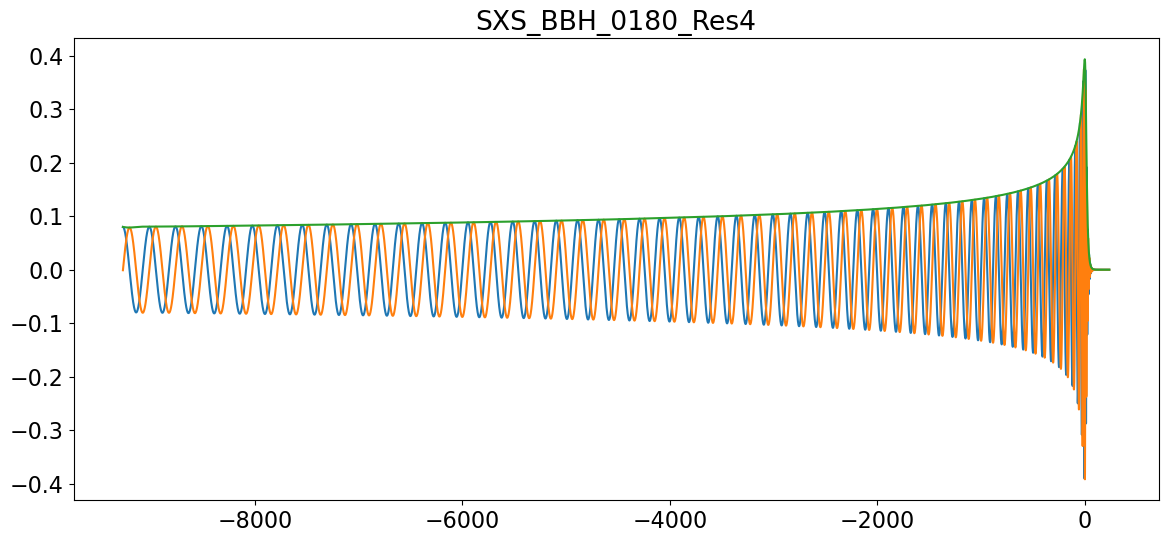

In [257]:
idx = 0
l_ = 2
m_ = 2

plt.figure(figsize=(14,6))
plt.plot(nr_data[idx][l_,m_].times, nr_data[idx][l_,m_].strain.real)
plt.plot(nr_data[idx][l_,m_].times, nr_data[idx][l_,m_].strain.imag)
plt.plot(nr_data[idx][l_,m_].times, np.abs(nr_data[idx][l_,m_].strain))
plt.title(metadata.iloc[idx]['simname'])
# plt.xlim(-100,100)

# compare waveforms

In [258]:
class Modes:
    def __init__(self, nr_data, t_min=-3000):
        nr_data = copy.deepcopy(nr_data)
        self.nr_data = nr_data
        self.times = self.nr_data[(2,2)].times

        self.t_min = t_min
        if self.t_min != None:
            self.mask = self.times >= self.t_min
            self.times = self.times[self.mask]
            for lm in self.nr_data.keys():
                self.nr_data[lm].strain = self.nr_data[lm].strain[self.mask]
            
        
    def get_amp_from_strain(self, l, m):
        return np.abs(self.nr_data[(l, m)].strain)
        
    def get_phase_from_strain(self, l, m):
        return np.unwrap(np.angle(self.nr_data[(l, m)].strain))
        
    def get_frequency_from_strain(self, l, m, filter_params=None):
        f = IUS(self.times, self.get_phase_from_strain(l,m)).derivative()(self.times)

        if filter_params != None:
            return savgol_filter(f, filter_params['window_length'], filter_params['polyorder'])
        else:
            return f

    def rotate_modes_polarisation(self, psi):
        for lm in self.nr_data.keys():
            self.nr_data[lm].strain = self.nr_data[lm].strain * np.exp(1.j*psi)
            
    def rotate_modes_phase(self, phi0):
        for lm in self.nr_data.keys():
            self.nr_data[lm].strain = self.nr_data[lm].strain * np.exp(1.j*lm[1]*phi0)

In [259]:


# modes = [Modes(nr_data[i]) for i in range(len(nr_data))]

In [260]:
metadata

simname         q
0   SXS_BBH_0180_Res4  1.000000
1   SXS_BBH_0169_Res3  1.999973
2   SXS_BBH_0167_Res5  3.999987
3   SXS_BBH_0107_Res5  4.999988
4   SXS_BBH_0063_Res5  7.999969
5   SXS_BBH_0303_Res3  9.999928
6   SXS_BBH_0055_Res5  4.999987
7   SXS_BBH_0166_Res5  5.999979
8   SXS_BBH_0168_Res5  2.999992
9   SXS_BBH_0295_Res5  4.499990
10  SXS_BBH_0296_Res5  5.499985
11  SXS_BBH_0294_Res4  3.499994
12  SXS_BBH_0297_Res5  6.499975
13  SXS_BBH_0298_Res5  6.999971
14  SXS_BBH_0299_Res5  7.499967
15  SXS_BBH_0300_Res5  8.499956
16  SXS_BBH_0301_Res5  8.999951
17  SXS_BBH_0302_Res5  9.499946
18  SXS_BBH_0007_Res5  1.499999
19  SXS_BBH_0186_Res3  8.267457
20  SXS_BBH_0259_Res5  2.499997

simname         q
4  SXS_BBH_0063_Res5  7.999969

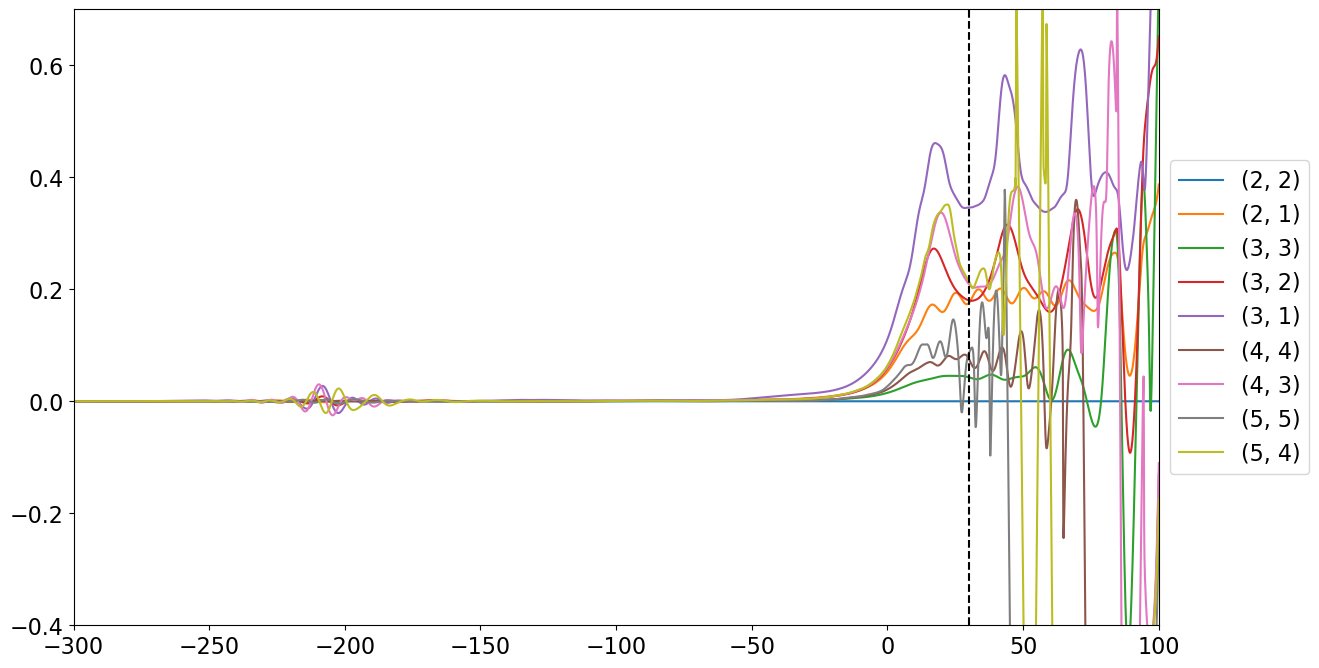

In [263]:
idx=4
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])


# filter_params = None
filter_params = {'window_length':100, 'polyorder':2}
plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_frequency_from_strain(lm[0], lm[1], filter_params) - mode.get_frequency_from_strain(2,2, filter_params)/2 * lm[1], label=lm)
    # plt.plot(mode.times, mode.get_frequency_from_strain(lm[0], lm[1], filter_params) - mode.get_frequency_from_strain(2,2, filter_params), label=lm)
plt.ylim(-0.4, 0.7)
plt.xlim(-300, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

(-100.0, 100.0)

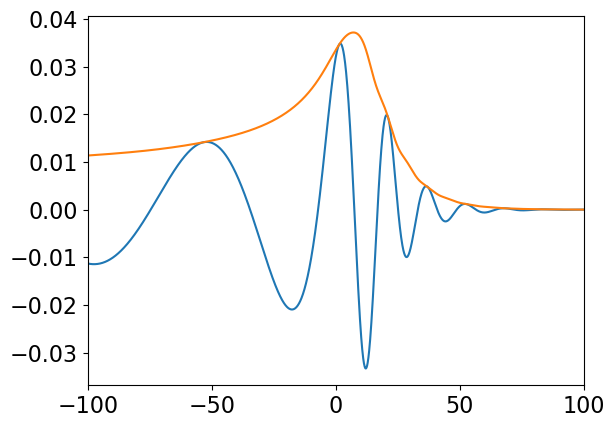

In [264]:
plt.plot(mode.times, mode.nr_data[(2,1)].strain.real)
plt.plot(mode.times, mode.get_amp_from_strain(2,1))
plt.xlim(-100, 100)

(-100.0, 100.0)

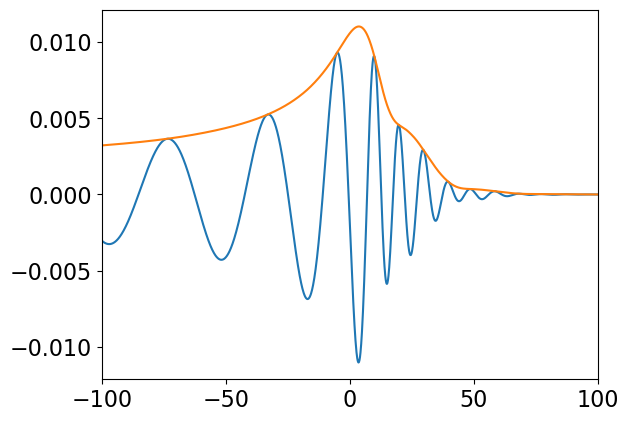

In [265]:
plt.plot(mode.times, mode.nr_data[(3,2)].strain.real)
plt.plot(mode.times, mode.get_amp_from_strain(3,2))
plt.xlim(-100, 100)

(-100.0, 100.0)

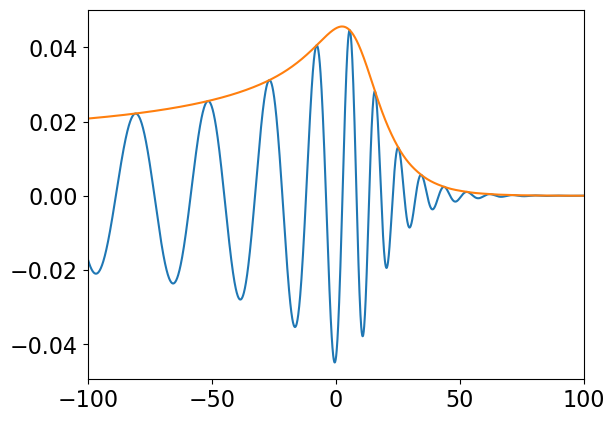

In [266]:
plt.plot(mode.times, mode.nr_data[(3,3)].strain.real)
plt.plot(mode.times, mode.get_amp_from_strain(3,3))
plt.xlim(-100, 100)

In [267]:
# https://arxiv.org/pdf/1708.00404.pdf
# eq. 7
# relative phase shifts for modes
def delta_lm(l, m):
    # return (np.pi/2) * (3*l + (l+m)%2) - np.pi # paper version has 3*l but that seems wrong
    # this is my guess
    return (np.pi/2) * (l + (l+m)%2) - np.pi
    

In [268]:
delta_lm(2,2)

0.0

In [269]:
delta_lm(2,1)

1.5707963267948966

In [270]:
delta_lm(3,3)

1.5707963267948966

In [271]:
delta_lm(4,4)

3.141592653589793

In [272]:
delta_lm(5,5) / (3*np.pi/2)

1.0

In [273]:
def delta_phi_fn(m):
    z = (-1)*(-1.j)**m
    return np.arctan2(z.imag, z.real)

In [274]:
delta_phi_fn(5)

1.5707963267948966

In [275]:
for m in [1,2,3,4,5]:
    print(m, delta_phi_fn(m))

1 1.5707963267948966
2 -0.0
3 -1.5707963267948966
4 3.141592653589793
5 1.5707963267948966


In [276]:
# before looking at phases perhaps i need to align them first ?

In [277]:
mode.get_phase_from_strain(2,2)[20000]

110.23608940143616

In [278]:
mode.times[20000]

-999.9186265039252

simname         q
1  SXS_BBH_0169_Res3  1.999973

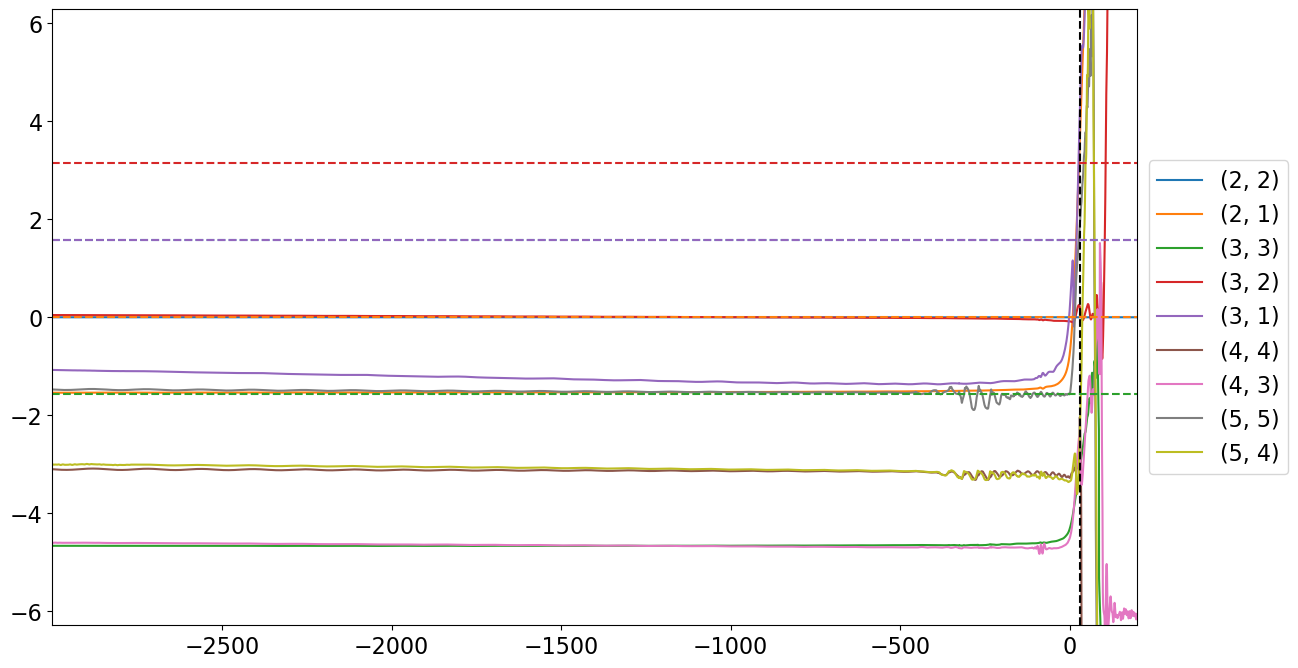

In [279]:
idx=1
mode = Modes(nr_data[idx])
# mode.rotate_modes_polarisation(-np.pi/2)
# mode.rotate_modes_phase(-np.pi/3)
display(metadata.iloc[[idx]])


plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_phase_from_strain(lm[0], lm[1]) - mode.get_phase_from_strain(2,2)/2 * lm[1], label=lm)
plt.ylim(-2*np.pi, 2*np.pi)
plt.xlim(mode.times[0], 200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

plt.axhline(delta_phi_fn(1), ls='--', c='C0')
plt.axhline(delta_phi_fn(2), ls='--', c='C1')
plt.axhline(delta_phi_fn(3), ls='--', c='C2')
plt.axhline(delta_phi_fn(4), ls='--', c='C3')
plt.axhline(delta_phi_fn(5), ls='--', c='C4')


In [280]:
lms

[(2, 2), (2, 1), (3, 3), (3, 2), (3, 1), (4, 4), (4, 3), (5, 5), (5, 4)]

simname         q
3  SXS_BBH_0107_Res5  4.999988

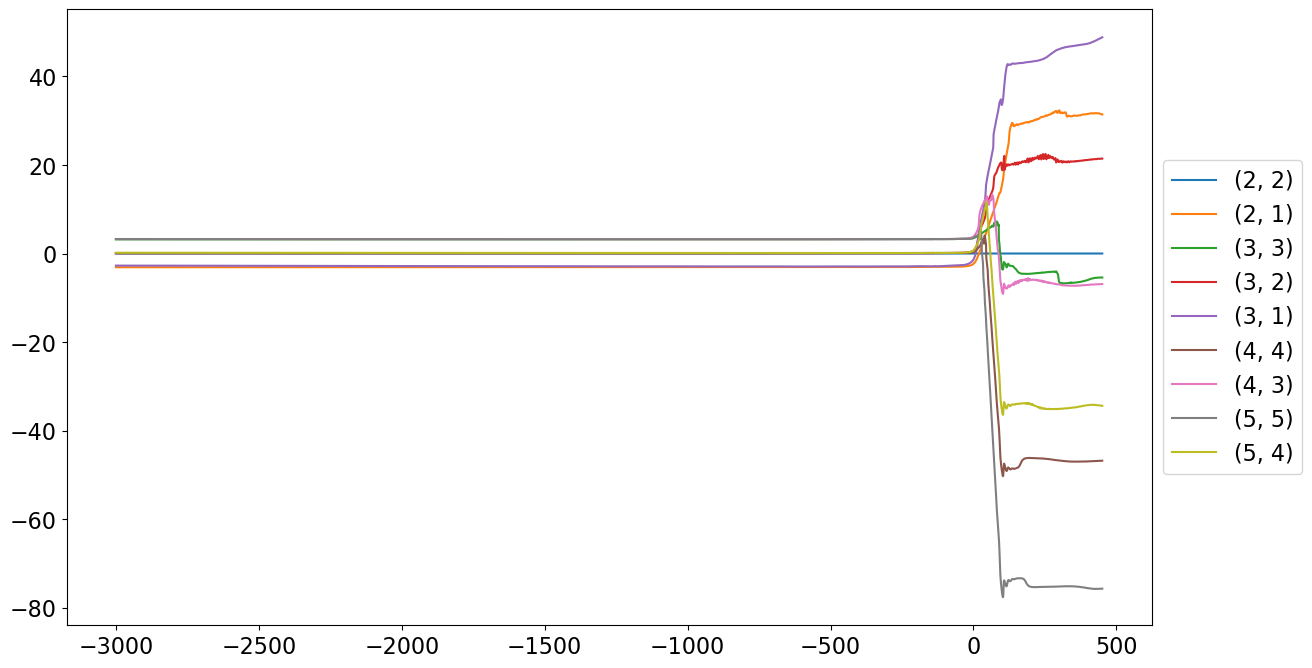

In [281]:
idx=3
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])


plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_phase_from_strain(lm[0], lm[1]) - (mode.get_phase_from_strain(2,2)/2 * lm[1]) - delta_phi_fn(lm[1]), label=lm)
# plt.ylim(-1,1)
# plt.xlim(mode.times[0], 200)
# plt.xlim(-100, 100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.axhline(np.pi, ls='--', c='k')
# plt.axhline(np.pi/2, ls='--', c='k')
# plt.axhline(3*np.pi/2, ls='--', c='k')
# plt.axhline(0, ls='--', c='k')
# plt.axhline(-np.pi/4, ls='--', c='k')
# plt.axhline(-np.pi/2, ls='--', c='k')

simname         q
3  SXS_BBH_0107_Res5  4.999988

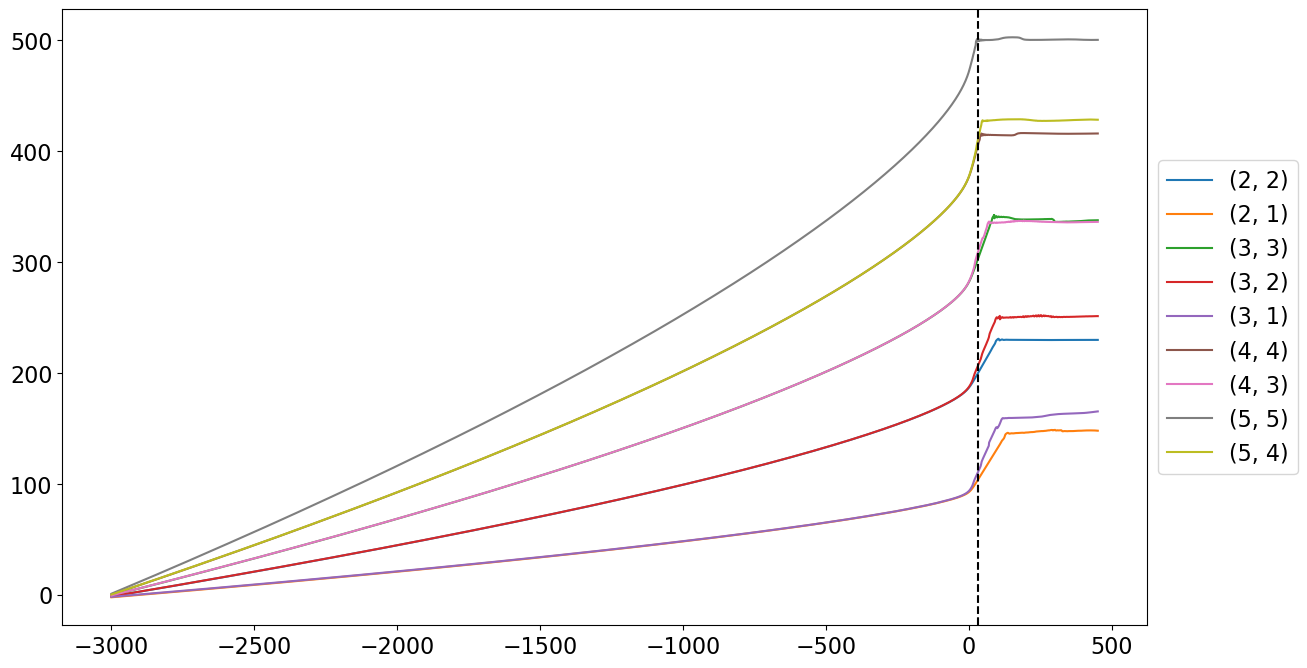

In [282]:
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])


plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_phase_from_strain(lm[0], lm[1]), label=lm)
# plt.ylim(-0.4, 0.4)
# plt.xlim(-300, 200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

simname         q
3  SXS_BBH_0107_Res5  4.999988

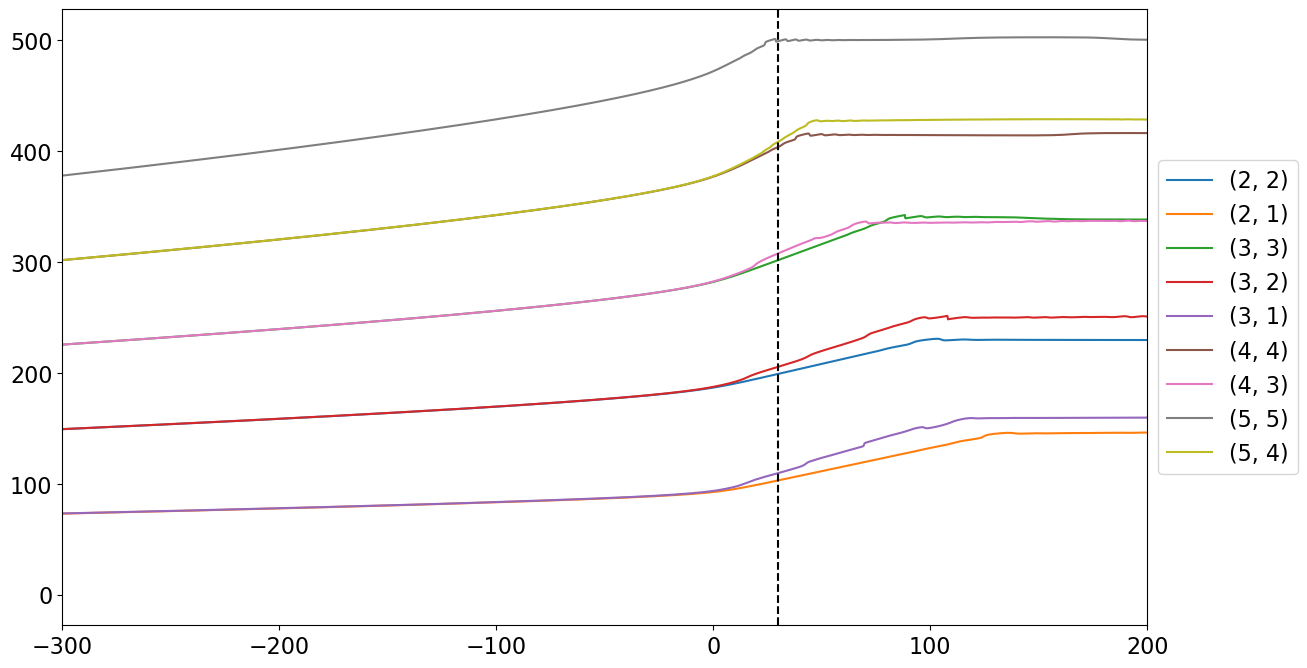

In [283]:
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])


plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_phase_from_strain(lm[0], lm[1]), label=lm)
# plt.ylim(-0.4, 0.4)
plt.xlim(-300, 200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

simname         q
3  SXS_BBH_0107_Res5  4.999988

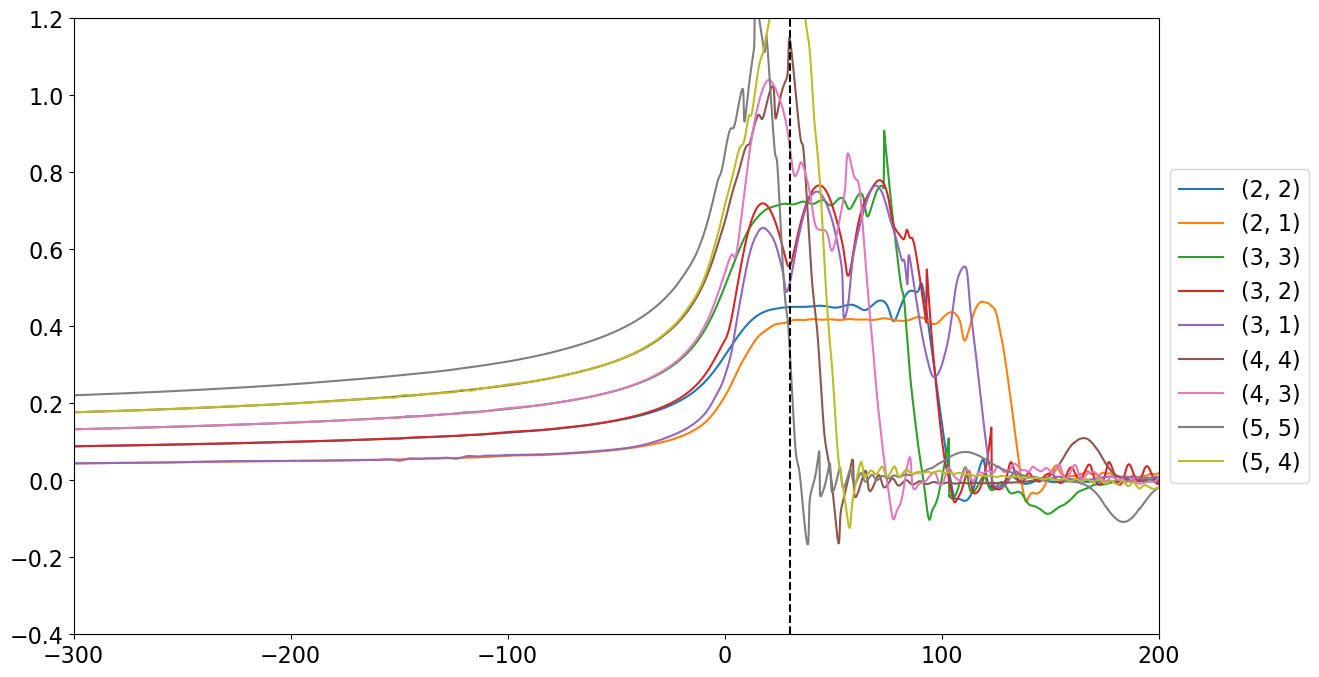

In [284]:
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])

# filter_params = None
filter_params = {'window_length':300, 'polyorder':2}
plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_frequency_from_strain(lm[0], lm[1], filter_params), label=lm)
plt.ylim(-0.4, 1.2)
plt.xlim(-300, 200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

simname         q
6  SXS_BBH_0055_Res5  4.999987

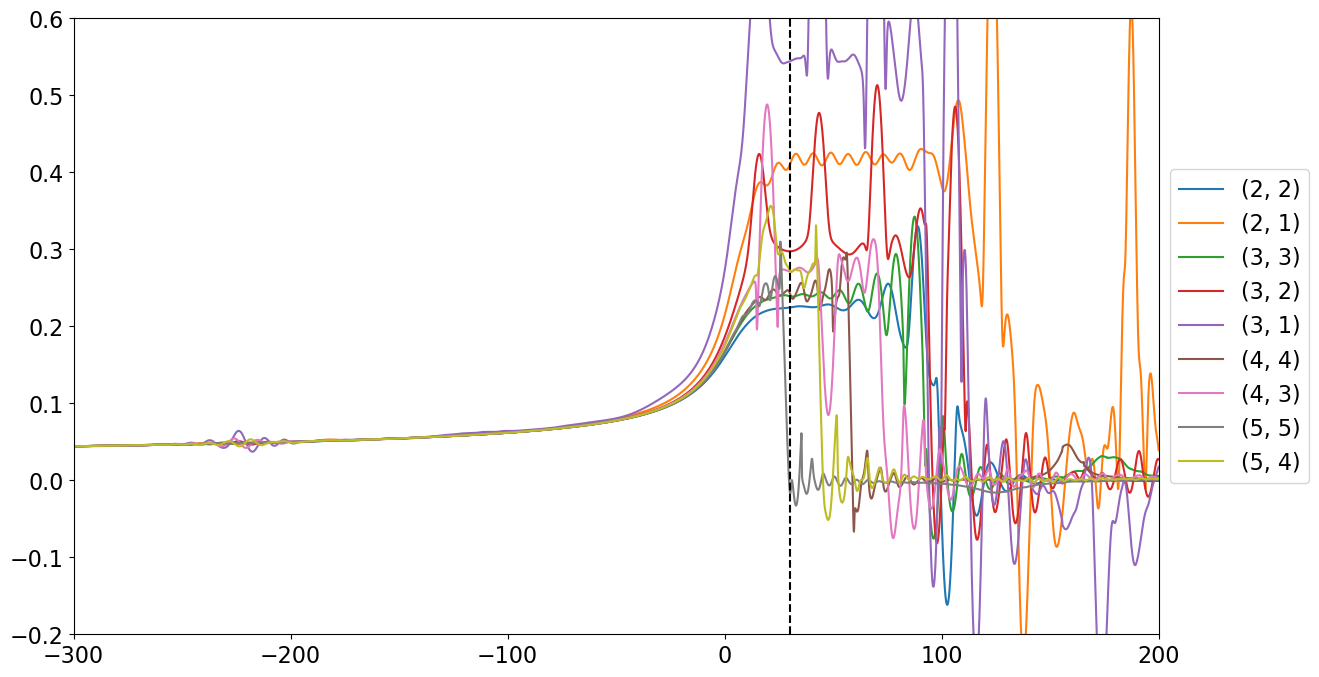

In [314]:
idx=6
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])

# filter_params = None
filter_params = {'window_length':100, 'polyorder':2}
plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_frequency_from_strain(lm[0], lm[1], filter_params)/lm[1], label=lm)
plt.ylim(-0.2, 0.6)
plt.xlim(-300, 200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

simname         q
3  SXS_BBH_0107_Res5  4.999988

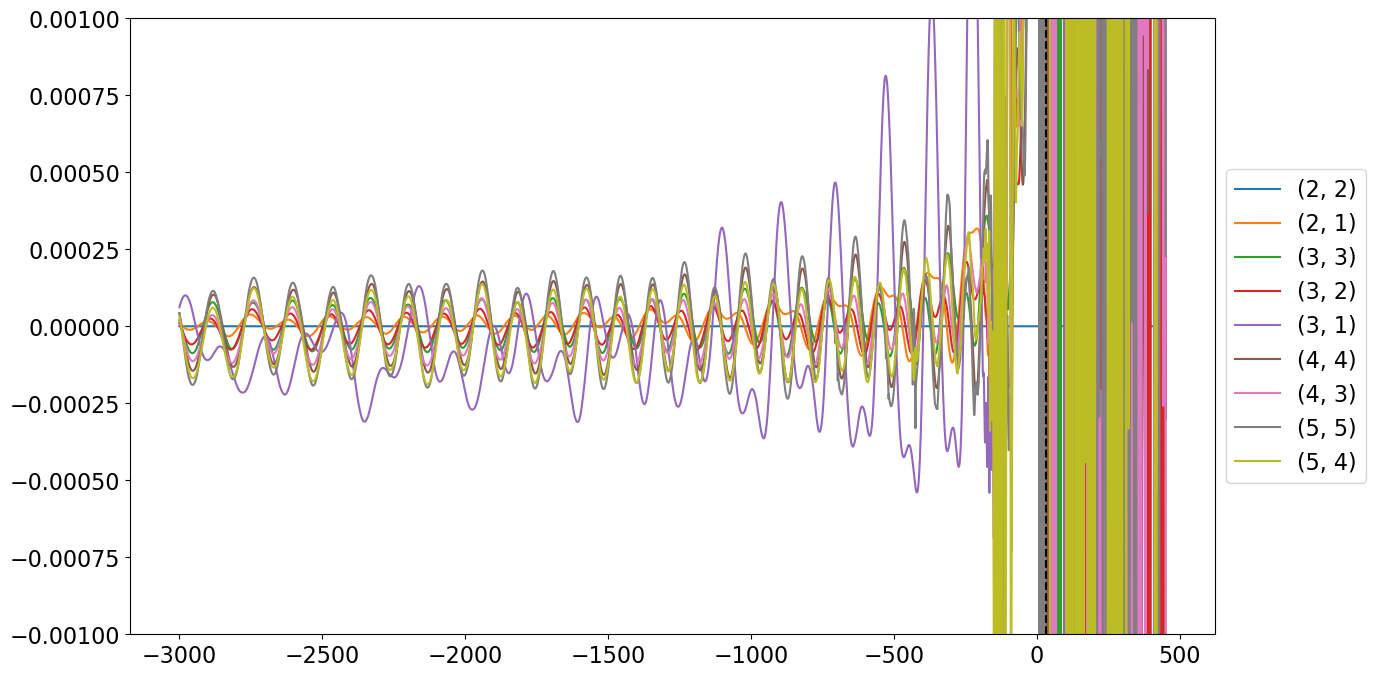

In [306]:
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])

# filter_params = None
filter_params = {'window_length':100, 'polyorder':2}
plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_frequency_from_strain(lm[0], lm[1], filter_params) - lm[1]*mode.get_frequency_from_strain(2, 2, filter_params)/2, label=lm)
plt.ylim(-0.001, 0.001)
# plt.xlim(-100, 200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

simname         q
3  SXS_BBH_0107_Res5  4.999988

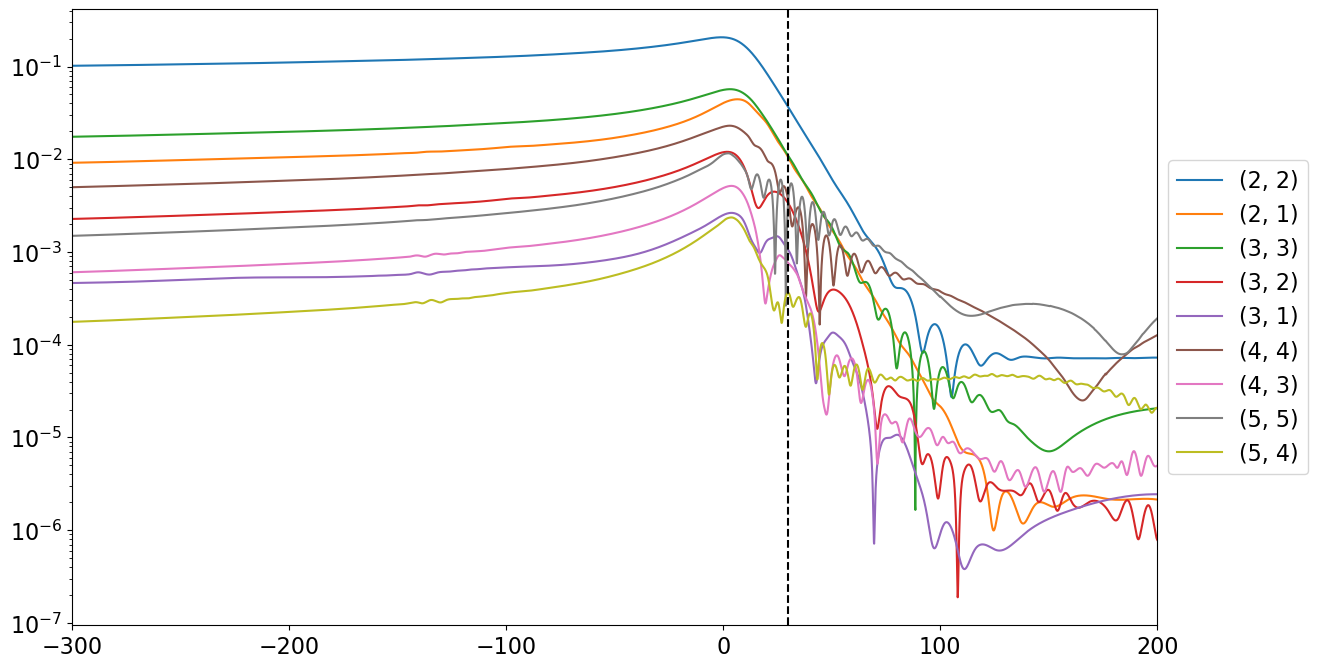

In [286]:
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])

# filter_params = None
filter_params = {'window_length':300, 'polyorder':2}
plt.figure(figsize=(14,8), dpi=100)
if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.plot(mode.times, mode.get_amp_from_strain(lm[0], lm[1]), label=lm)
plt.yscale('log')
plt.xlim(-300, 200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(30, c='k', ls='--')

simname         q
3  SXS_BBH_0107_Res5  4.999988

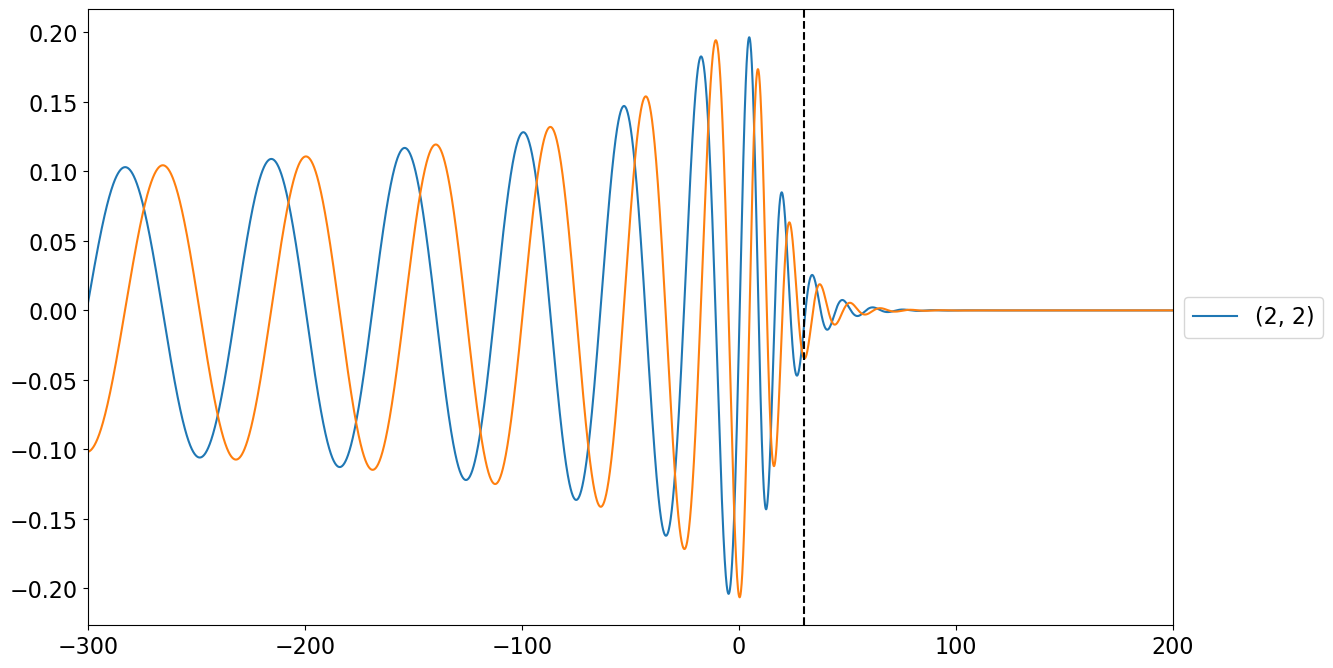

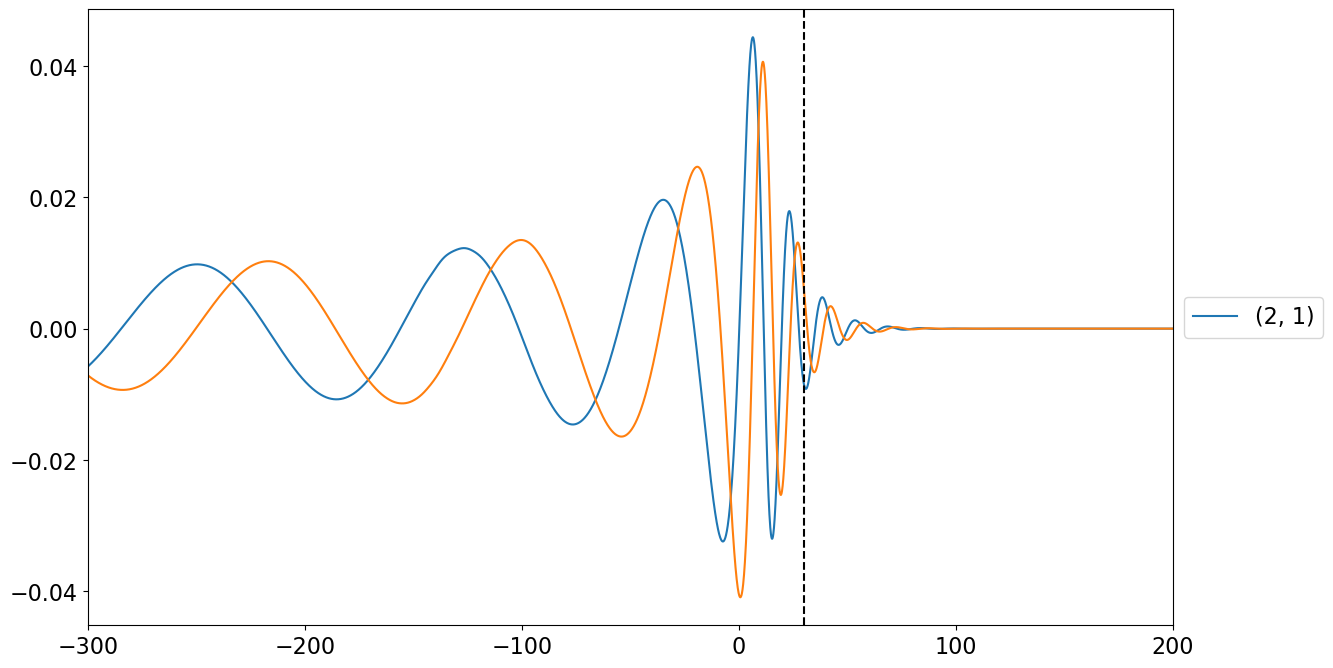

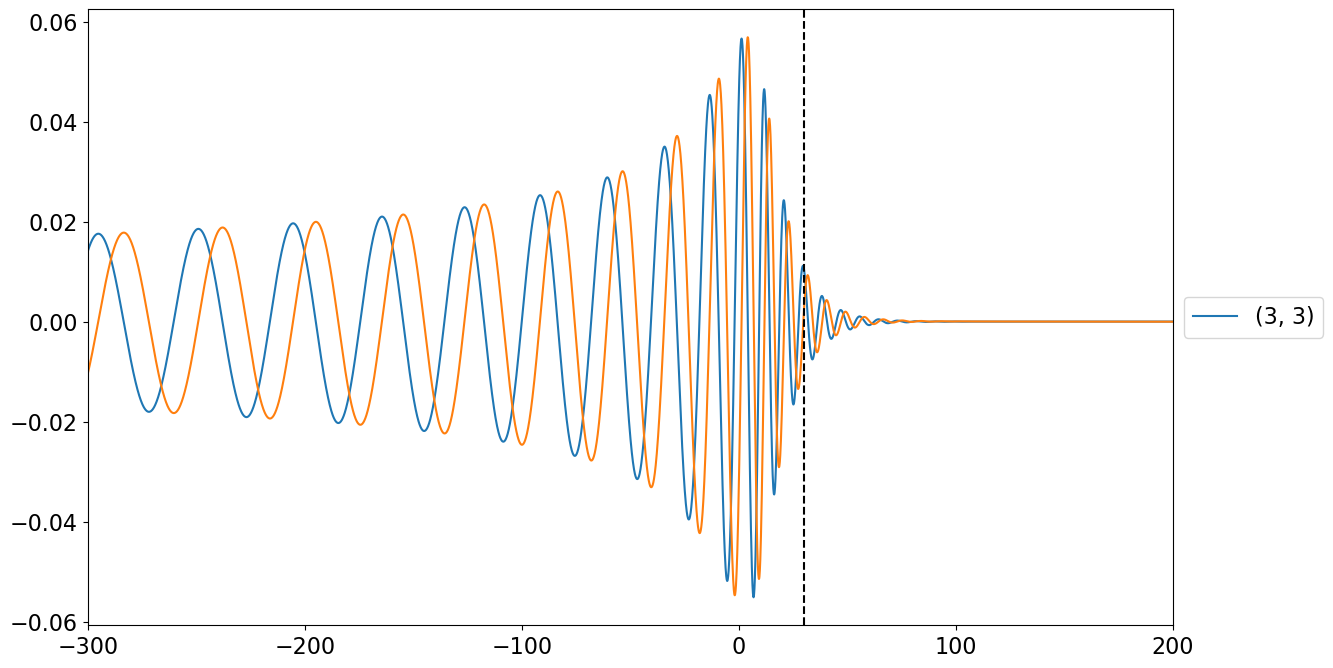

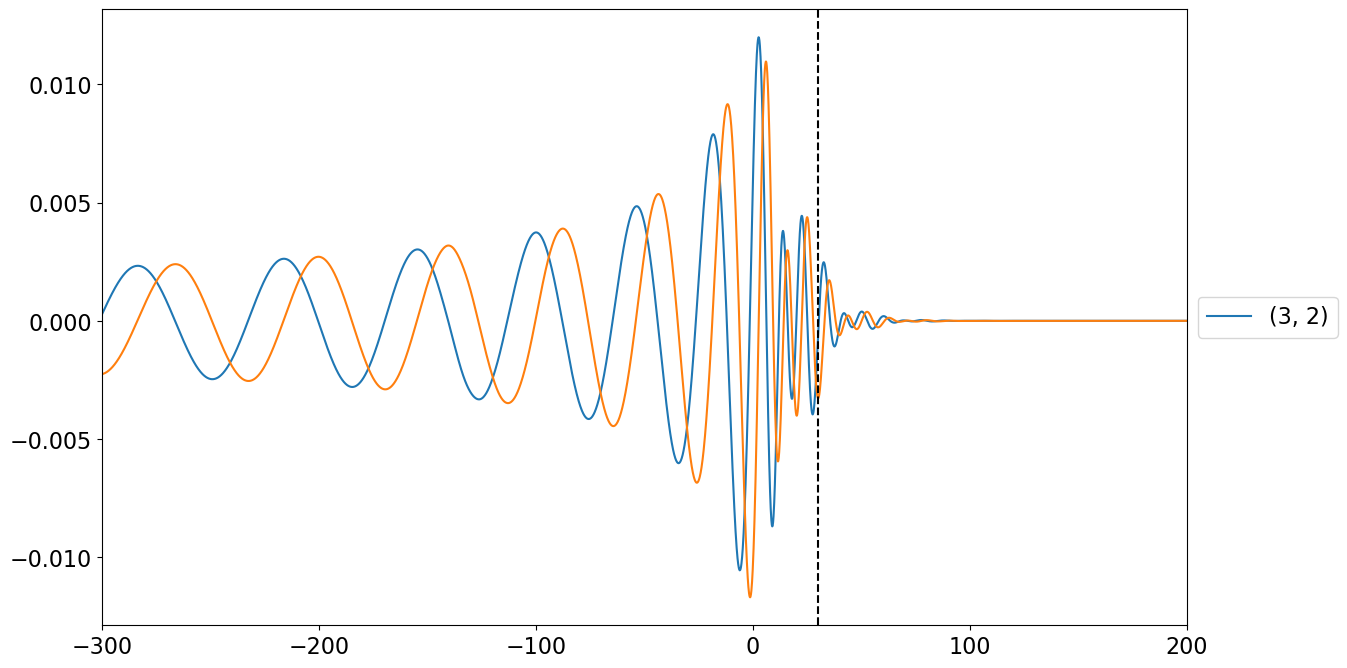

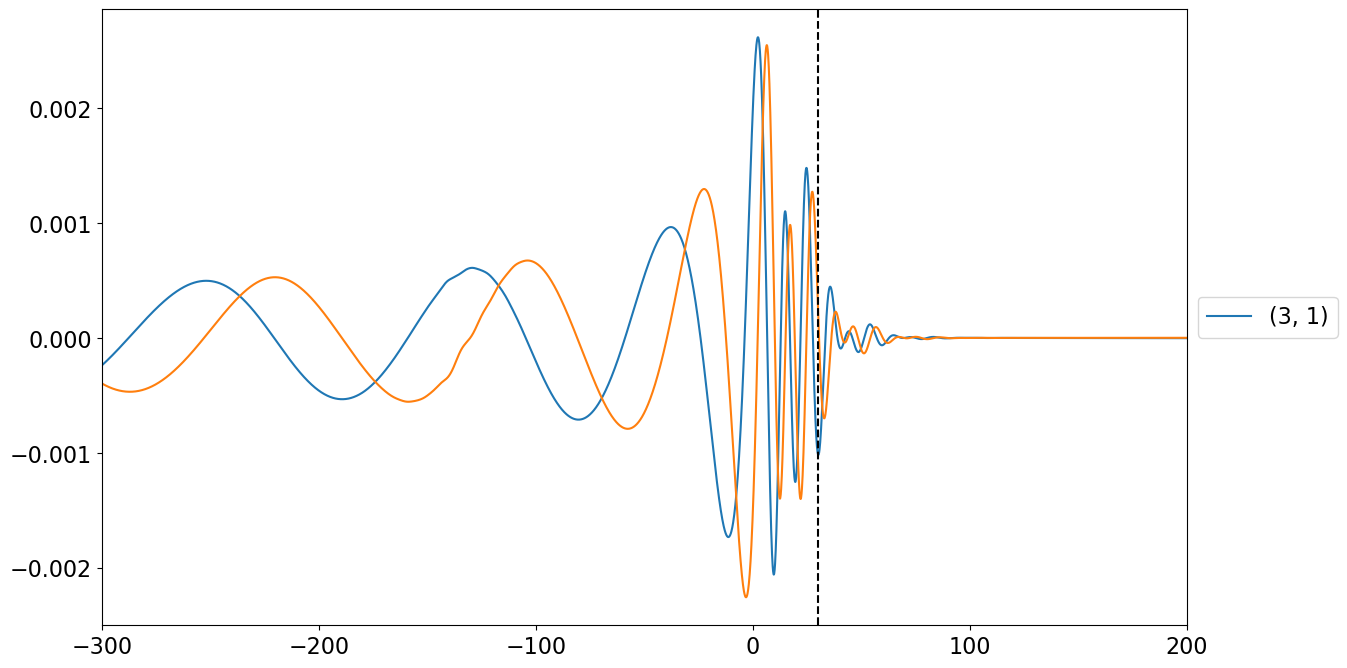

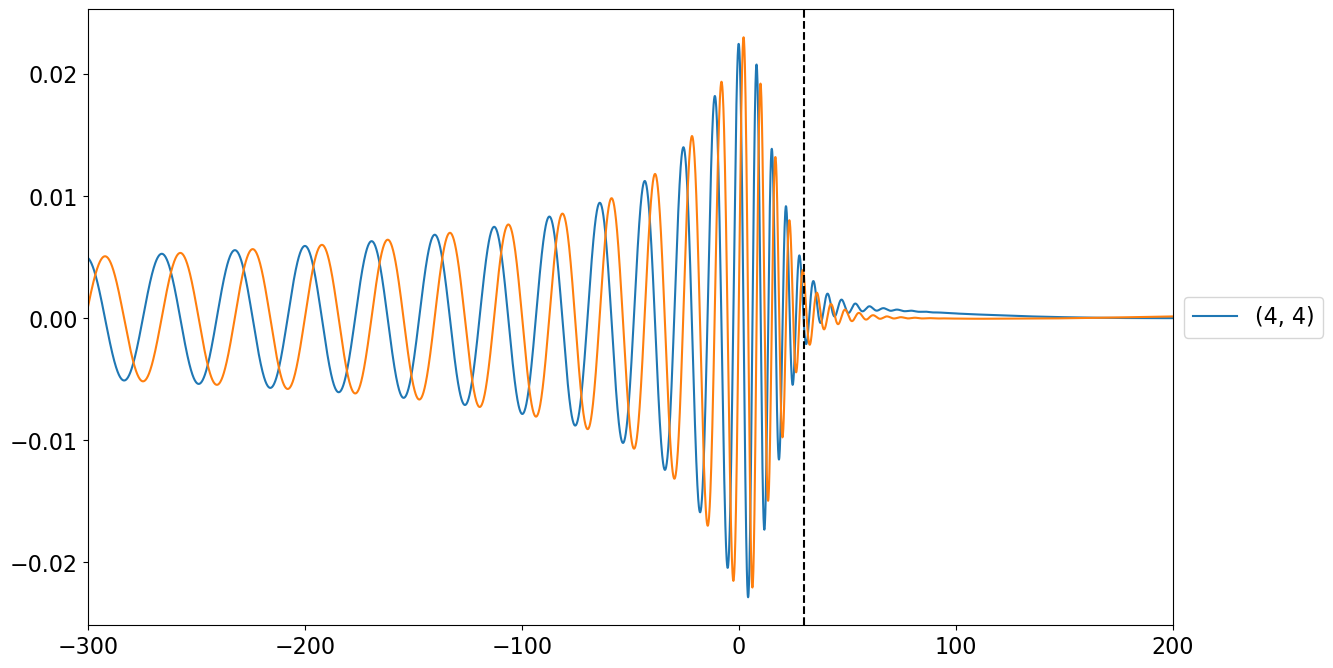

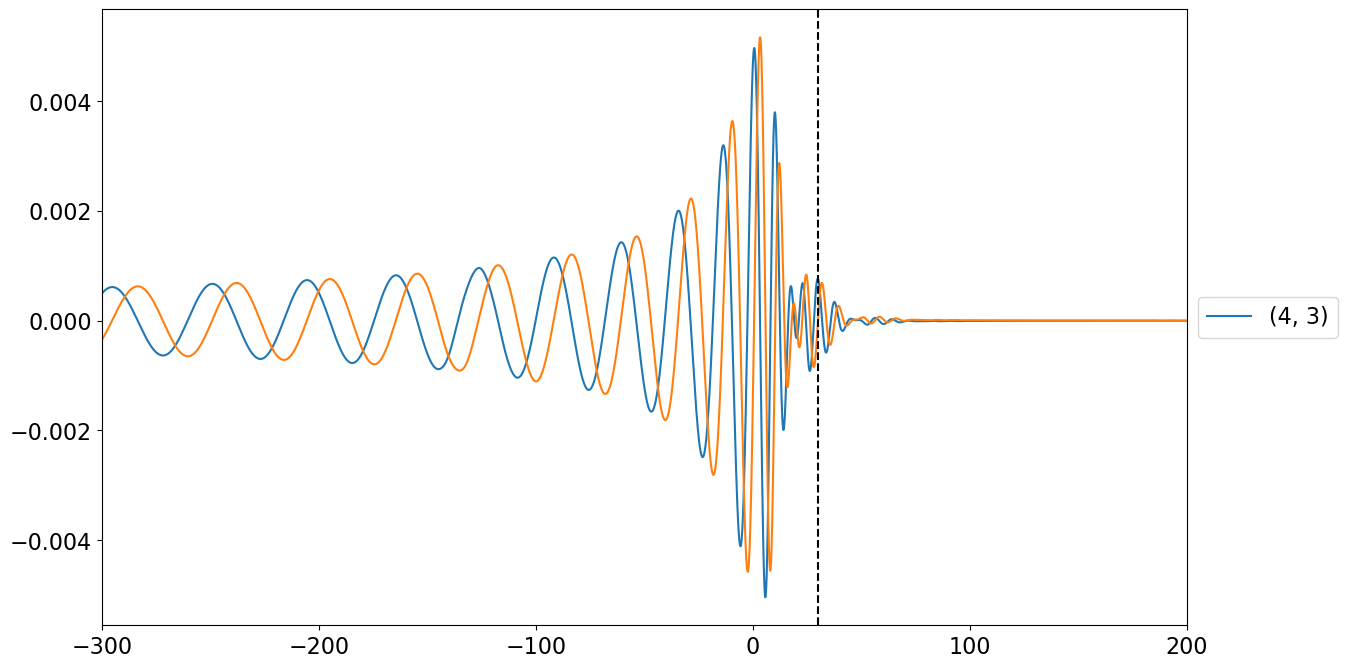

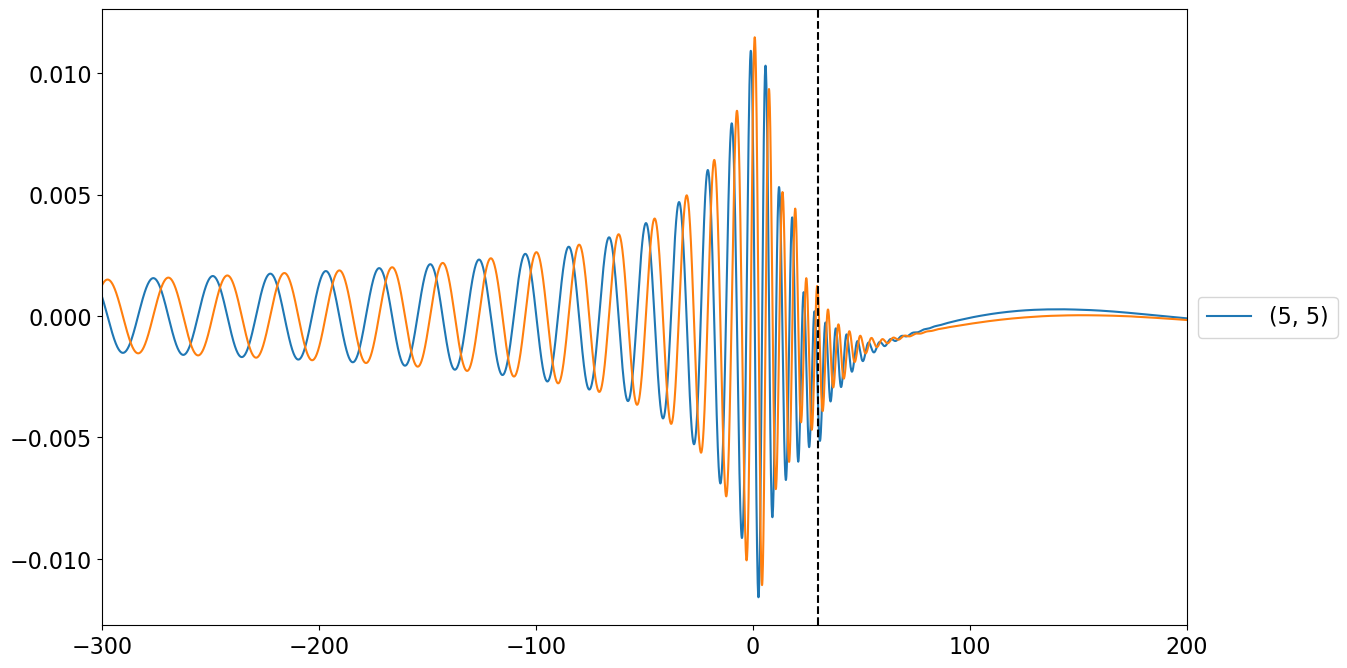

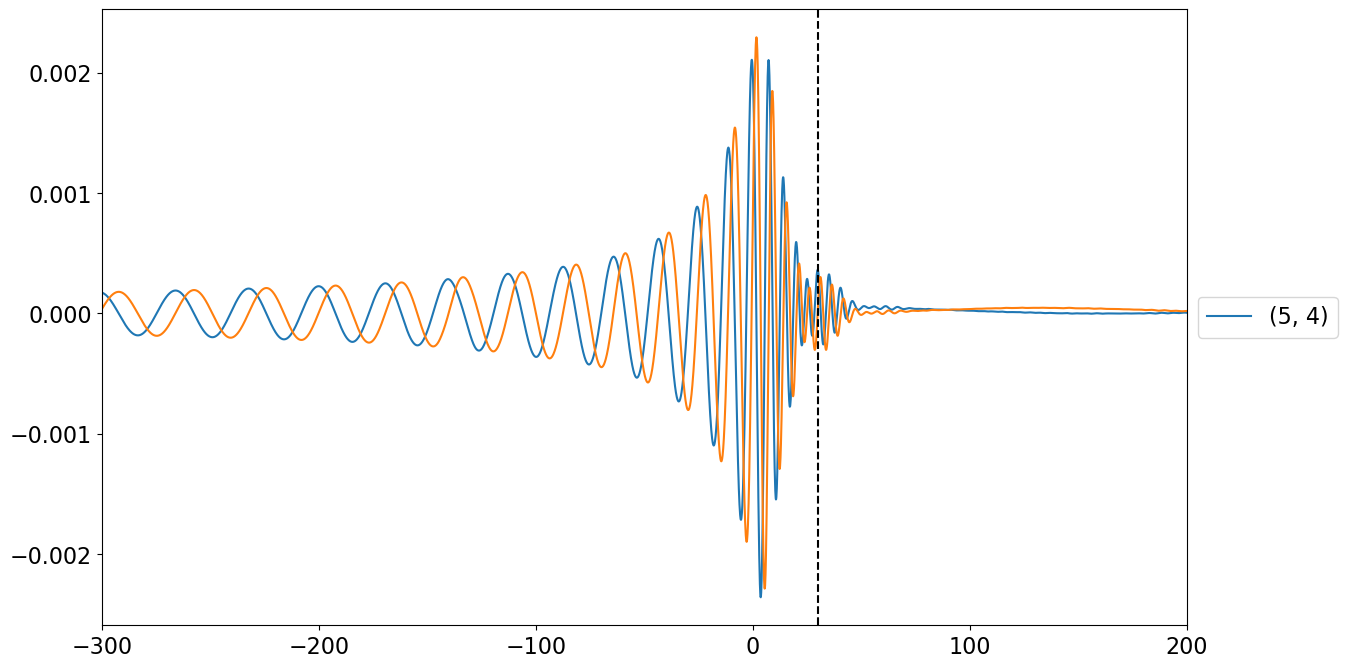

In [287]:
mode = Modes(nr_data[idx])
display(metadata.iloc[[idx]])

# filter_params = None

if (np.around(metadata.iloc[[idx]]['q'].values[0],2) == 1.0):
    lms_ = [(2,2), (3,2), (4,4), (5,4)]
else:
    lms_ = lms
for lm in lms_:
    plt.figure(figsize=(14,8), dpi=100)
    plt.plot(mode.times, mode.nr_data[(lm[0], lm[1])].strain.real, label=lm)
    plt.plot(mode.times, mode.nr_data[(lm[0], lm[1])].strain.imag)
    plt.xlim(-300, 200)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axvline(30, c='k', ls='--')
    plt.show()
    plt.close()

In [288]:

###
# new idea: hybridise GPR + ringdown perturbation theory to extend NR ringdown cleanly to make fitting the phase easier?
###


(-0.4, 0.4)

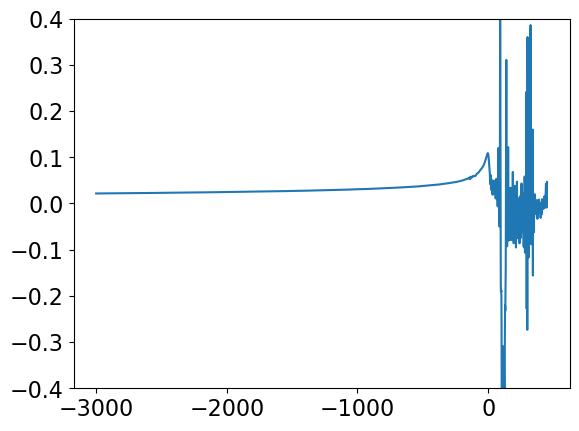

In [289]:
plt.plot(mode.times, mode.get_frequency_from_strain(2,2)-mode.get_frequency_from_strain(2,1))
plt.ylim(-0.4, 0.4)
# plt.xlim(-100, 100)

(-100.0, 100.0)

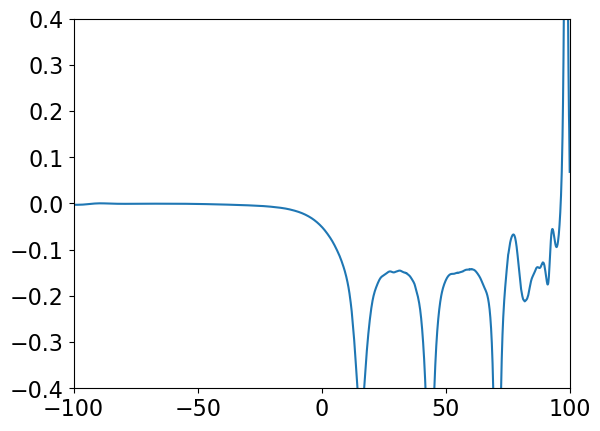

In [290]:
plt.plot(mode.times, mode.get_frequency_from_strain(2,2)-mode.get_frequency_from_strain(3,2))
plt.ylim(-0.4, 0.4)
plt.xlim(-100, 100)

(-0.4, 0.4)

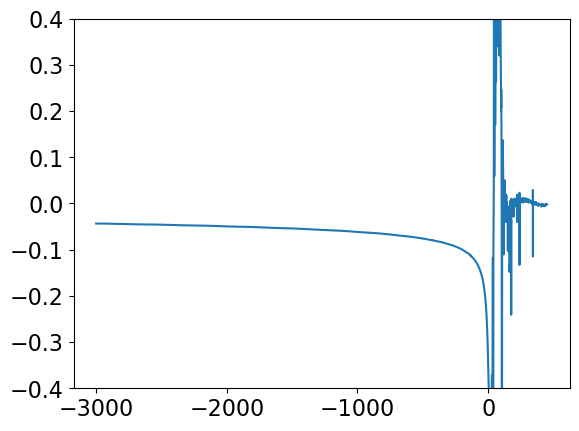

In [291]:
plt.plot(mode.times, mode.get_frequency_from_strain(2,2)-mode.get_frequency_from_strain(4,4))
# plt.plot(mode.times, mode.get_phase_from_strain(2,2)-mode.get_phase_from_strain(3,2))
plt.ylim(-0.4, 0.4)
# plt.xlim(-100, 100)